In [79]:
%matplotlib inline

import pickle
import copy
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
xgb.set_config(verbosity=0)
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

In [80]:
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
from matplotlib import pyplot

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [81]:
path = 'data/Human_protein/'

In [82]:
df = pd.read_csv(path+'final_dataset.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,Source,Destination,Class,Page_Rank_Src,Page_Rank_Dst,Shortest_Path,adar,katz_s,katz_d,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees
0,1,2,1,0.000253,0.000651,2,0.0,0.020863,0.022439,0.000000,0.0,0.0,0.000000
1,3,4,1,0.000844,0.000373,5,0.0,0.021082,0.021080,0.000000,0.0,0.0,0.000000
2,5,6,1,0.000087,0.000384,3,0.0,0.020552,0.022019,0.000000,0.0,0.0,0.000000
3,1,7,1,0.000253,0.000610,2,0.0,0.020863,0.022018,0.000000,0.0,0.0,0.000000
4,8,9,1,0.000416,0.000489,2,0.0,0.021291,0.022958,0.034483,0.0,0.0,0.016433


In [83]:
g = nx.from_pandas_edgelist(df[['Source','Destination']], source='Source', target='Destination',create_using=nx.DiGraph())

In [84]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

In [85]:
df['Source'] = df['Source'].astype('float')
df['Destination'] = df['Destination'].astype('float')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12904 entries, 0 to 12903
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Source             12904 non-null  float64
 1   Destination        12904 non-null  float64
 2   Class              12904 non-null  int64  
 3   Page_Rank_Src      12904 non-null  float64
 4   Page_Rank_Dst      12904 non-null  float64
 5   Shortest_Path      12904 non-null  int64  
 6   adar               12904 non-null  float64
 7   katz_s             12904 non-null  float64
 8   katz_d             12904 non-null  float64
 9   jaccard_followers  12904 non-null  float64
 10  jaccard_followees  12904 non-null  float64
 11  cosine_followers   12904 non-null  float64
 12  cosine_followees   12904 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 1.3 MB


In [87]:
df_x = df.drop(columns=['Source', 'Destination', 'Class'])
df_y = df[['Class']]


In [88]:
trans = MinMaxScaler()
data = trans.fit_transform(df_x)
dataset = pd.DataFrame(df_x)


In [89]:
df_x = pd.DataFrame(preprocessing.scale(df_x))

In [90]:
x_train, x_test, y_train, y_test  = train_test_split(df_x, df_y, test_size = 0.4)

In [91]:
df_x

,0,1,2,3,4,5,6,7,8,9
0,-0.685815,0.384315,-1.057040,-0.12966,-0.467532,1.972118,-0.291013,-0.130417,-0.195986,-0.274604
1,1.470135,-0.524530,0.452705,-0.12966,0.104798,-0.613519,-0.291013,-0.130417,-0.195986,-0.274604
2,-1.289570,-0.488488,-0.553791,-0.12966,-1.284263,1.172099,-0.291013,-0.130417,-0.195986,-0.274604
3,-0.685815,0.251322,-1.057040,-0.12966,-0.467532,1.171780,-0.291013,-0.130417,-0.195986,-0.274604
4,-0.091279,-0.145412,-1.057040,-0.12966,0.654573,2.959254,0.747115,-0.130417,-0.195986,0.405844
...,...,...,...,...,...,...,...,...,...,...
12899,0.608770,-0.622652,0.452705,-0.12966,0.100624,-0.821930,-0.291013,-0.130417,-0.195986,-0.274604
12900,-0.929901,-1.187193,-0.553791,-0.12966,0.093781,-0.618196,3.054065,-0.130417,-0.195986,3.428937
12901,-0.093653,0.408047,-2.566784,-0.12966,-0.188370,-1.017521,-0.291013,-0.130417,-0.195986,-0.274604
12902,-0.669765,0.660687,-2.566784,-0.12966,-0.461907,0.788001,-0.291013,-0.130417,-0.195986,-0.274604


In [92]:
df_y

,Class
0,1
1,1
2,1
3,1
4,1
...,...
12899,0
12900,0
12901,0
12902,0


In [93]:
df_y['Class'].value_counts().to_frame().T

,1,0
Class,6452,6452


In [94]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

# print(confusion_matrix(y_train, y_pred))

In [95]:
acc = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 0.900


In [96]:
final_score=cross_val_score(xgb_model,df_x,df_y,cv=5)

In [97]:
final_score.mean()

0.8829063309996427

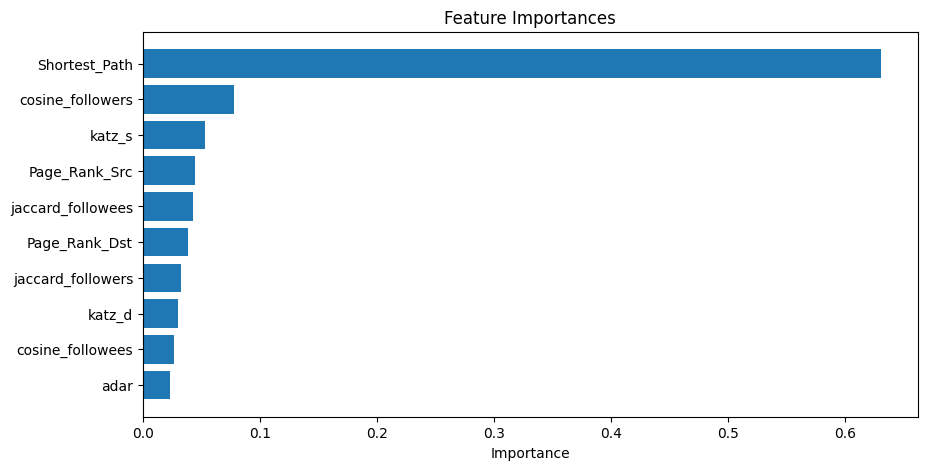

In [98]:
features = df.columns.drop(['Class', 'Source', 'Destination'])
imp = xgb_model.feature_importances_
idx = (np.argsort(imp))[-25:]
plt.figure(figsize=(10,5))
plt.title('Feature Importances')
plt.barh(range(len(idx)), imp[idx], color='tab:blue', align='center')
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.xlabel('Importance')
plt.savefig(path+'importance_plot.png',bbox_inches='tight')
plt.show()

In [99]:
global values,ini_list
values=[]

In [100]:
ini_list=[]
def ini_call():
    ini_list.append(values)

In [101]:

def De_Algorithm(fobj, bounds, mut=0.8, crossp=0.7, popsize=100, its=1000):
    
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]

    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        if i==0:
            ini_call()
        print("Iteration number= %s" % (i))
        yield best, fitness[best_idx]

In [102]:

def xgb2(X_training, y_training, X_valid, y_valid, w):

      temp=[]
      temp.append(w)

      w[1] = round(w[1])
      w[2] = round(w[2])
      w[6] = round(w[6])
      w[7] = round(w[7])
      w[8] = round(w[8])
      w[9] = round(w[9])
      w[10] = round(w[10])
      
      params = {'eta': w[0], # 0.3,
            'tree_method': "hist",
            'grow_policy': "lossguide",
            'max_leaves': w[1], # 1400,  
            'max_depth': w[2], # 0, 
            'subsample': w[3], # 0.9, 
            'colsample_bytree': w[4], # 0.7, 
            'colsample_bylevel': w[5], # 0.7,
            'min_child_weight': w[6], # 0,
            'alpha': w[7], # 4,
            'objective': 'binary:logistic', 
            'scale_pos_weight': w[8], # 9,
            'eval_metric': 'auc', 
            'nthread': w[9], # 8,
            'random_state': w[10], # 99, 
            'silent': True}
      
      dtrain = xgb.DMatrix(X_training, y_training)
      dvalid = xgb.DMatrix(X_valid, y_valid)
      
      watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
      
      model = xgb.train(params, dtrain, 10)
      
      X_valid = xgb.DMatrix(X_valid)
      y_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
      predictions = [round(value) for value in y_pred]

      accuracy = accuracy_score(y_valid, predictions)
      auc = roc_auc_score(y_valid, predictions)
      print(f"Accuracy: ",round((accuracy * 100.0),4),"%  Loss: ",round((1-accuracy),4))

      temp.append(1-accuracy)
      values.append(temp)

      return model, accuracy

In [103]:
xgb2(x_train,y_train,x_test,y_test,[0.1,4,2,0.1,0.1,0.1,3,2,2,2,2])

Accuracy:  51.0461 %  Loss:  0.4895


(<xgboost.core.Booster at 0x7fec1c4b7b80>, 0.5104610616040295)

In [104]:

def Objective_Function2(w):
    w = w.tolist()
    model2, accuracy = xgb2(x_train, y_train, x_test, y_test, w)
    return (1-accuracy)

In [105]:

result = list(De_Algorithm(Objective_Function2,
                 [(0.001,1),   
                  (3,1500),  
                  (0,20),  
                  (0,1),  
                  (0.001,1),  
                  (0.001,1),   
                  (0.001,1),  
                  (2,8),   
                  (1,10),  
                  (1,10),    
                  (1,10)],
                  mut=0.1, crossp=0.3, popsize=10, its=20))

Accuracy:  75.8814 %  Loss:  0.2412
Accuracy:  79.659 %  Loss:  0.2034
Accuracy:  69.1592 %  Loss:  0.3084
Accuracy:  75.184 %  Loss:  0.2482
Accuracy:  71.5808 %  Loss:  0.2842
Accuracy:  84.9864 %  Loss:  0.1501
Accuracy:  51.2011 %  Loss:  0.488
Accuracy:  85.1802 %  Loss:  0.1482
Accuracy:  80.2402 %  Loss:  0.1976
Accuracy:  49.7094 %  Loss:  0.5029
Accuracy:  64.8005 %  Loss:  0.352
Accuracy:  79.659 %  Loss:  0.2034
Accuracy:  78.0511 %  Loss:  0.2195
Accuracy:  49.7094 %  Loss:  0.5029
Accuracy:  70.6122 %  Loss:  0.2939
Accuracy:  76.2301 %  Loss:  0.2377
Accuracy:  68.5587 %  Loss:  0.3144
Accuracy:  84.0566 %  Loss:  0.1594
Accuracy:  79.7365 %  Loss:  0.2026
Accuracy:  49.7094 %  Loss:  0.5029
Iteration number= 0
Accuracy:  65.9241 %  Loss:  0.3408
Accuracy:  76.4626 %  Loss:  0.2354
Accuracy:  65.7885 %  Loss:  0.3421
Accuracy:  75.184 %  Loss:  0.2482
Accuracy:  68.6362 %  Loss:  0.3136
Accuracy:  50.2906 %  Loss:  0.4971
Accuracy:  59.2793 %  Loss:  0.4072
Accuracy:  85.

In [106]:
ini_list=ini_list[0]

In [107]:
pop_denorm=[]
fit=[]
for i in range(len(ini_list)):
    pop_denorm.append(ini_list[i][0])
    fit.append(ini_list[i][1])


In [108]:
array=[]
for i in range(len(pop_denorm)):
    array.append([fit[i], pop_denorm[i][0], pop_denorm[i][1], pop_denorm[i][2],pop_denorm[i][3],pop_denorm[i][4],pop_denorm[i][5],pop_denorm[i][6],pop_denorm[i][7],pop_denorm[i][8],pop_denorm[i][9],pop_denorm[i][10]])

In [109]:
df1 = pd.DataFrame(array, columns =['Fitness','w1','w2','w3','w4','w5','w6','w7','w8','w9','w10','w11'])
df1 = df1.sort_values(by=['Fitness'], ascending=False)
df1=df1.reset_index()
df1=df1.drop(['index'],axis=1)
df1

,Fitness,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11
0,0.502906,0.018010,878,8,0.228998,0.272357,0.331286,0,6,5,2,8
1,0.502906,0.018010,88,19,0.228998,0.178018,0.331286,1,5,5,2,8
2,0.502906,0.018010,88,2,0.228998,0.178018,0.331286,1,6,5,1,8
3,0.502906,0.018010,831,9,1.000000,0.246066,0.331286,1,5,5,2,8
4,0.502906,0.018010,88,2,0.228998,0.178018,0.331286,0,5,5,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...
206,0.113716,0.687936,792,15,0.986416,0.477758,1.000000,1,5,1,8,6
207,0.113716,0.687936,792,15,0.986416,0.477758,1.000000,1,5,1,8,6
208,0.113134,0.760073,1139,13,0.997531,0.422208,1.000000,1,6,1,4,6
209,0.113134,0.760073,1139,13,0.997531,0.422208,1.000000,1,6,1,8,6


In [110]:
df = pd.DataFrame(result)
def Best_coffs(df):

    df['w1'], df['w2'], df['w3'], df['w4'], df['w5'], df['w6'], df['w7'], df['w8'], df['w9'], df['w10'], df['w11']   = zip(*df[0]) 
    cols = [0] 
    df.drop(df.columns[cols],axis = 1,inplace = True) 
    df.columns.values[0] = "Fitness" 
    best_coff = df.iloc[len(df)-1,1:] 
    return best_coff
Best_coffs(df)

w1        0.760073
w2     1138.672162
w3       12.960981
w4        0.997531
w5        0.422208
w6        1.000000
w7        0.828844
w8        5.555793
w9        1.011268
w10       7.597935
w11       6.254690
Name: 19, dtype: float64

In [111]:
frames = [df1, df]
df = pd.concat(frames)
df = df.sort_values(by=['Fitness'], ascending=False)
df=df.reset_index()
df=df.drop(['index'],axis=1)

df

,Fitness,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11
0,0.502906,0.018010,878.000000,8.000000,0.228998,0.272357,0.331286,0.000000,6.000000,5.000000,2.000000,8.00000
1,0.502906,0.018010,88.000000,19.000000,0.228998,0.178018,0.331286,1.000000,5.000000,5.000000,2.000000,8.00000
2,0.502906,0.018010,88.000000,2.000000,0.228998,0.178018,0.331286,1.000000,6.000000,5.000000,1.000000,8.00000
3,0.502906,0.018010,831.000000,9.000000,1.000000,0.246066,0.331286,1.000000,5.000000,5.000000,2.000000,8.00000
4,0.502906,0.018010,88.000000,2.000000,0.228998,0.178018,0.331286,0.000000,5.000000,5.000000,3.000000,6.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.113134,0.760073,1139.000000,13.000000,0.997531,0.422208,1.000000,1.000000,6.000000,1.000000,4.000000,6.00000
227,0.113134,0.760073,1138.672162,12.960981,0.997531,0.422208,1.000000,0.828844,5.555793,1.011268,7.597935,6.25469
228,0.113134,0.760073,1138.672162,12.960981,0.997531,0.422208,1.000000,0.828844,5.555793,1.011268,7.597935,6.25469
229,0.113134,0.760073,1138.672162,12.960981,0.997531,0.422208,1.000000,0.828844,5.555793,1.011268,7.597935,6.25469


In [112]:
df.to_csv(path+'result.csv')

In [113]:
def Plot_DEA_Evolution(df):
    
    data_ncol=len(df.columns) 
    fig = plt.figure(figsize=(20,15)) 

    for i in range(1,(data_ncol+1)):
        if i<(data_ncol):
            
            plt.subplot(3, 4, i)
            plt.plot(df['w{}'.format(i)],'bo', markersize=4)
            plt.xlabel('Iteration')
            plt.ylabel('w{}'.format(i))
            plt.grid(True)
        else:       
            plt.subplot(3, 4, data_ncol)
            plt.plot(df['Fitness'],'red', markersize=4)
            plt.xlabel('')
            plt.ylabel('Loss')
            plt.grid(True)
    
    plt.savefig(path+'result_plot.png',bbox_inches='tight')
    plt.show()

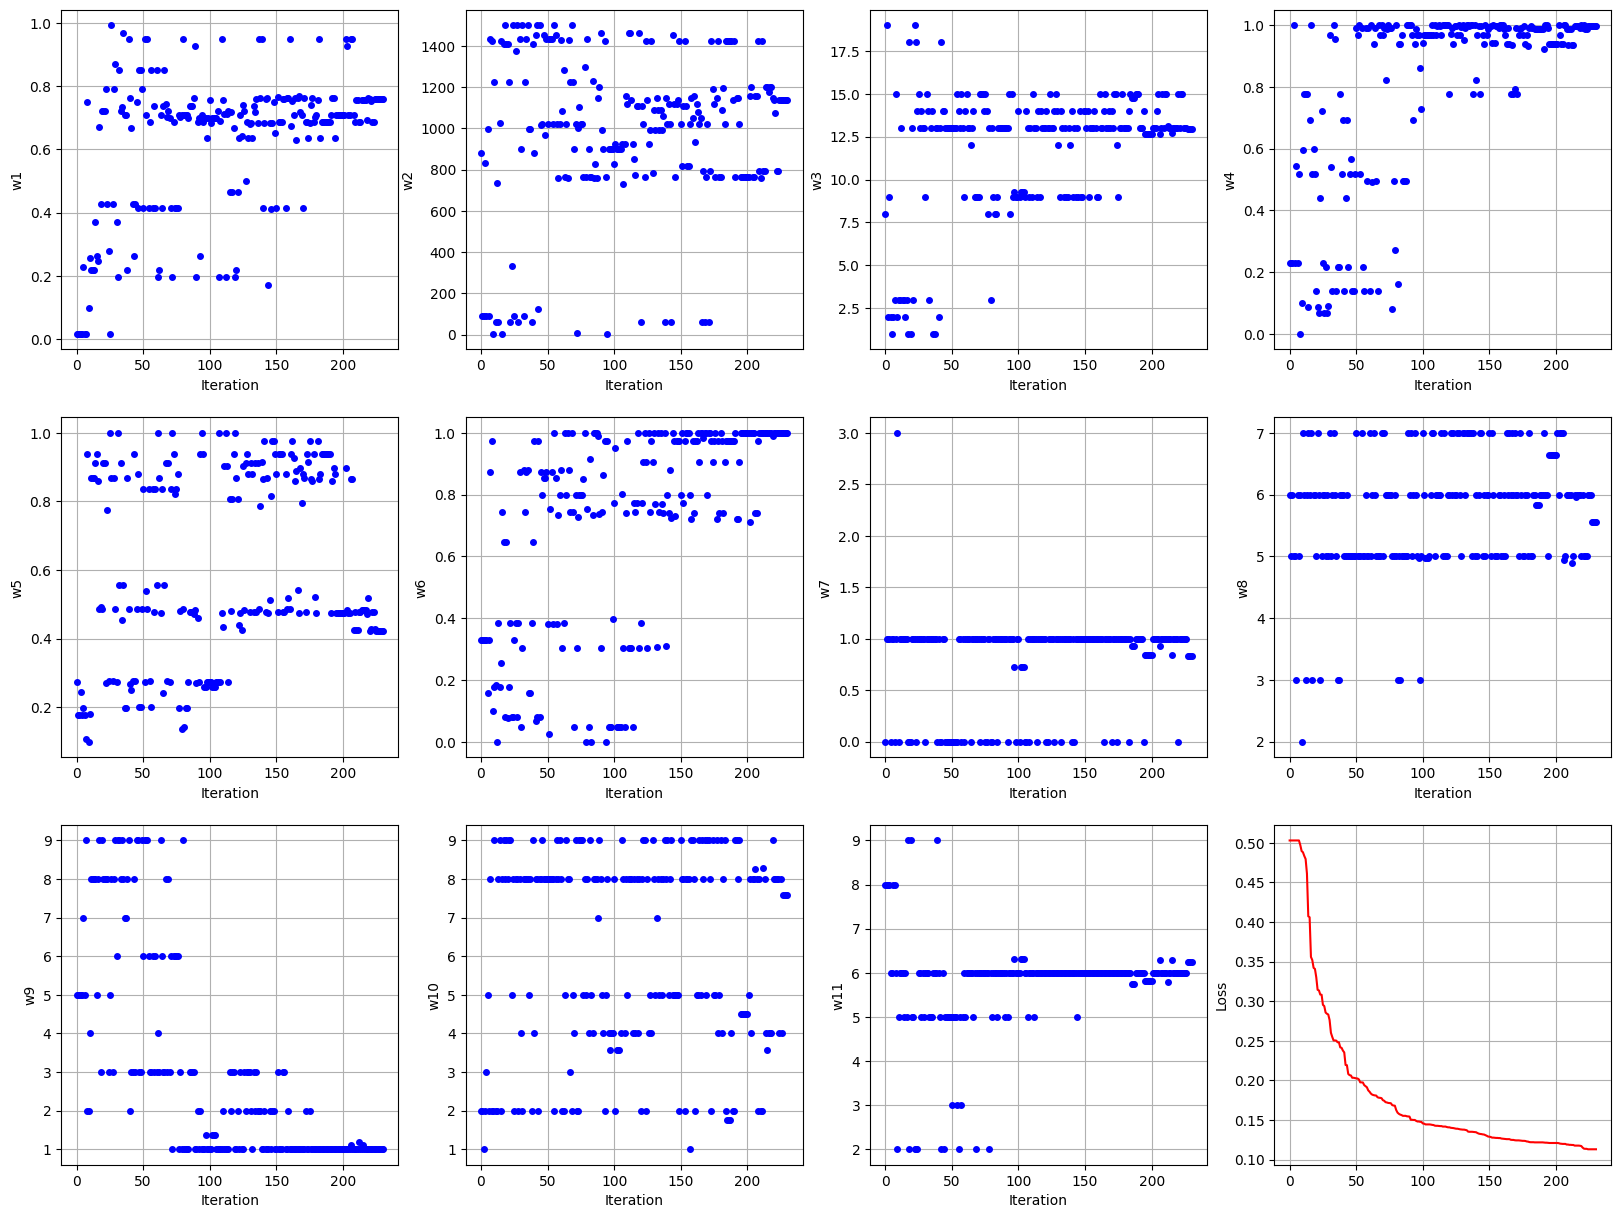

In [114]:
Plot_DEA_Evolution(df)

In [115]:
df = pd.DataFrame(result)
def Best_coffs(df):

    
    df['eta'], df['max_leaves'],df['max_depth'], df['subsample'],df['colsample_bytree'], df['colsample_bylevel'],df['min_child_weight'], df['alpha'],df['scale_pos_weight'], df['nthread'], df['random_state'] = zip(*df[0]) 
    cols = [0] 
    df.drop(df.columns[cols],axis = 1,inplace = True) 
    df.columns.values[0] = "Fitness" 
    best_Parameters = df.iloc[len(df)-1,1:]
    return best_Parameters

def print_hyper_parameters(df):
    
    best_Parameters = Best_coffs(df)
    best_Parameters[1] = round(best_Parameters[1])
    best_Parameters[2] = round(best_Parameters[2])
    best_Parameters[6] = round(best_Parameters[6])
    best_Parameters[7] = round(best_Parameters[7])
    best_Parameters[8] = round(best_Parameters[8])
    best_Parameters[9] = round(best_Parameters[9])
    best_Parameters[10] = round(best_Parameters[10])
    

    
    print(best_Parameters)
    
print_hyper_parameters(df)   

eta                     0.760073
max_leaves           1139.000000
max_depth              13.000000
subsample               0.997531
colsample_bytree        0.422208
colsample_bylevel       1.000000
min_child_weight        1.000000
alpha                   6.000000
scale_pos_weight        1.000000
nthread                 8.000000
random_state            6.000000
Name: 19, dtype: float64


In [116]:
df = pd.DataFrame(result)
w = list(Best_coffs(df))
w

[0.7600732766622463,
 1138.6721622478103,
 12.960981217954338,
 0.9975305111657292,
 0.42220803109978583,
 1.0,
 0.8288438269030143,
 5.555792823068623,
 1.0112683915374336,
 7.597934535726648,
 6.254689642616912]

In [117]:
df = pd.DataFrame(result)
w = list(Best_coffs(df))
Trained_Model, accuracy = xgb2(x_train, y_train, x_test, y_test, w)

Accuracy:  88.6866 %  Loss:  0.1131
